In [5]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim
from matplotlib import cm

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,  # input height
                out_channels=16,  # n_filters
                kernel_size=5,  # filter size
                stride=1,  # filter movement/step
                padding=2,
                # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),  # output shape (16, 28, 28)
            nn.ReLU(),  # activation
            nn.MaxPool2d(kernel_size=2),  # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)  # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x  # return x for visualization

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')
    plt.show()
    plt.pause(0.01)

In [6]:
torch.manual_seed(1)  # reproducible
# Hyper Parameters
HAS_SK = True
EPOCH = 3  # 训练数据的次数
BATCH_SIZE = 50
LR = 1e-3

torch.Size([10000, 28, 28])
tensor(7)


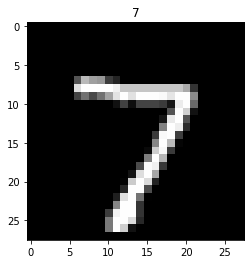

torch.Size([2000, 1, 28, 28])
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2931
| test accuracy: 1.00
the linear layer: torch.Size([2000, 1568])


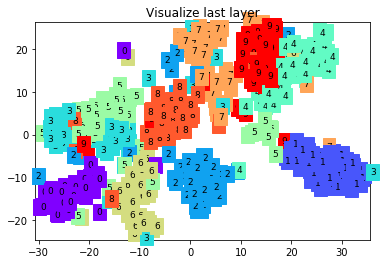

Epoch:  0 | train loss: 2.1627
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


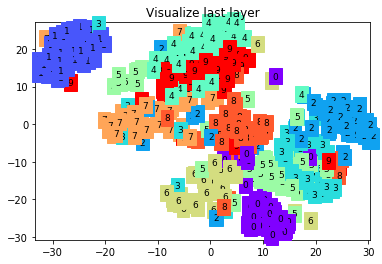

Epoch:  1 | train loss: 2.0408
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


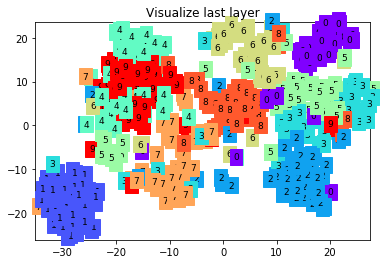

Epoch:  1 | train loss: 0.7483
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


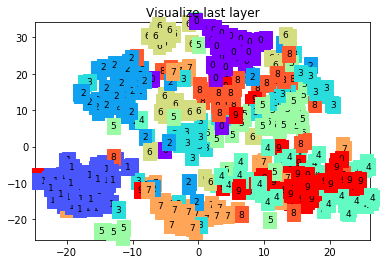

Epoch:  2 | train loss: 0.7507
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


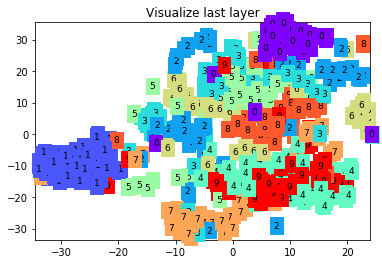

Epoch:  2 | train loss: 0.4000
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


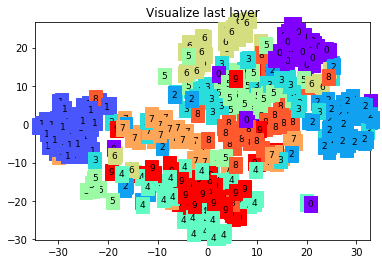

Epoch:  3 | train loss: 0.4031
| test accuracy: 0.00
the linear layer: torch.Size([2000, 1568])


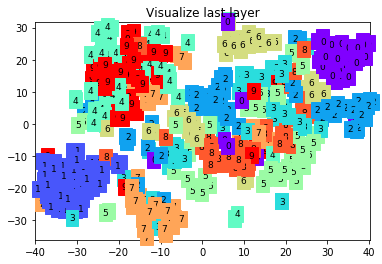

Epoch:  3 | train loss: 0.4849
| test accuracy: 1.00
the linear layer: torch.Size([2000, 1568])


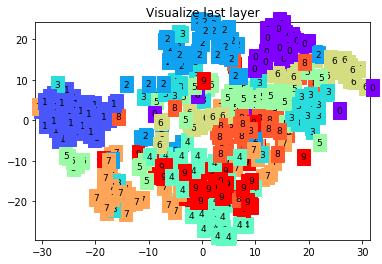

Epoch:  4 | train loss: 0.4385
| test accuracy: 1.00
the linear layer: torch.Size([2000, 1568])


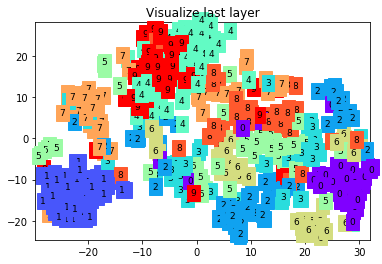

Epoch:  4 | train loss: 0.3131
| test accuracy: 1.00
the linear layer: torch.Size([2000, 1568])


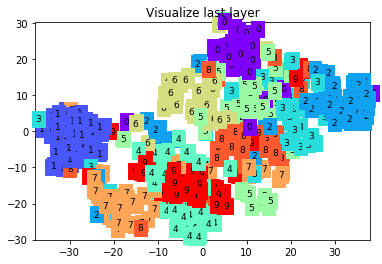

In [143]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data',  # 选择数据的根目录
                               train=True,  # 选择训练集，
                               transform=transforms.ToTensor(),  # 转换成tensor变量
                               download=False)  # 不从网络上download图片

test_dataset = datasets.MNIST(root='./data',  # 选择数据的根目录
                              train=False,  # 选择测试集,
                              transform=transforms.ToTensor(),  # 转换成tensor变量
                              download=False)  # 不从网络上download图片
# plot one example
print(test_dataset.test_data.shape)  # (60000, 28, 28)
print(test_dataset.test_labels[0])  # (60000)
plt.imshow(test_dataset.test_data[0].numpy(), cmap='gray')
plt.title('%i' % test_dataset.test_labels[0])
plt.show()
plt.ion()
if not torch.cuda.current_device() == None:
    device = torch.cuda.current_device()
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Dataloader 方便于打包数据训练, 图片的张量维度形式为 (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)  # 将数据打乱

with torch.no_grad():
    # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
    test_x = torch.unsqueeze(test_dataset.test_data, dim=1).type(torch.FloatTensor)[:2000] / 255.  
    test_y = test_dataset.test_labels[:2000]
    
print(test_x.shape)
def walk():
    cnn = CNN().to(device)
    print(cnn)  # 输出卷积神经网络结构
    optimizer = optim.SGD(cnn.parameters(), lr=LR)  # optimize all cnn parameters
    loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
    # 训练以及测试
    cnn.train() 
    for epoch in range(EPOCH):
        for step, (data, target) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # 为训练步骤清除梯度
            output,aux = cnn(data)  # CNN输出
            loss = loss_func(output, target) # 交叉熵损失
            optimizer.zero_grad() # 为训练步骤清除梯度
            loss.backward() # 反向传播, 计算梯度
            optimizer.step() #应用梯度更新权重

            if step % 1000 == 0:
                test_output, last_layer = cnn(test_x.cpu().cuda())
                pred_y = torch.max(test_output.cpu(), 1)[1].data.squeeze()
                accuracy = sum(pred_y == test_y) / float(test_y.size(0))
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
                print('| test accuracy: %.2f' % accuracy)
                if HAS_SK:
                    # 将训练的平直层可视化 (T-SNE)
                    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                    plot_only = 500
                    last_layer = last_layer.cpu()
                    print("the linear layer:",last_layer.size())
                    low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                    labels = test_y.numpy()[:plot_only]
                    plot_with_labels(low_dim_embs, labels)
    plt.ioff()
    
walk()


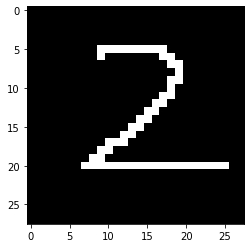

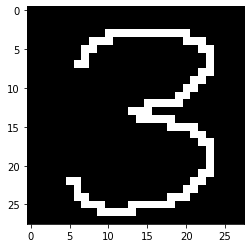

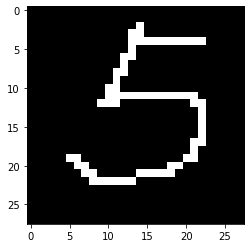

torch.Size([3, 1, 28, 28])
[2 3 5]


In [138]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def getGray(img_path):
    img = cv2.imread(img_path)
    size = (28, 28) 
    img = cv2.resize(img,size)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imgs = ['./images/2.png','./images/3.png','./images/5.png']

myX = []
for img in imgs:
    gray_img = getGray(img)
    gray_img = (255 - gray_img)
    myX.append(gray_img)
    plt.imshow(gray_img,cmap='gray')
    plt.show()
myX = torch.tensor(myX)
myX = torch.unsqueeze(myX, dim=1).type(torch.FloatTensor)[:2000] / 255.
print(myX.shape)

model = torch.load('cnn.pkl')
the_y,_ = model(myX.cuda())
predThe_y = torch.max(the_y.cpu(),1)[1].data.numpy()
print(predThe_y)

